In [66]:
import statsmodels
import scipy
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt
from scipy import stats
import itertools
from scipy.stats import pearsonr
from statsmodels.stats.proportion import proportion_confint
from statsmodels.sandbox.stats.multicomp import multipletests 

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('churn_analysis.csv')

In [4]:
data.head()

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

Для этого мы воспользуемся критерием хи-квадрат. Постройте таблицы сопряженности между каждой из всех 1275 возможных неупорядоченных пар штатов и значением признака churn. Для каждой такой таблицы 2x2 применить критерий хи-квадрат можно с помощью функции
scipy.stats.chi2_contingency(subtable, correction=False)
Заметьте, что, например, (AZ, HI) и (HI, AZ) — это одна и та же пара. Обязательно выставьте correction=False (о том, что это значит, вы узнаете из следующих вопросов).

Сколько достигаемых уровней значимости оказались меньше, чем $\alpha=0.05$?

In [5]:
states_pairs = list(itertools.combinations(set(data.state.values), 2))

In [6]:
def table_creator(data):
    """creates pivot table
    """
    a = data.state[(data.churn=='False.')].value_counts()
    b = data.state[(data.churn=='True.')].value_counts()
    states_stat = pd.DataFrame(a)
    states_stat.rename(columns={"state": "False"}, inplace=True)
    states_stat["True"] = a
    states_stat = states_stat.T
    return states_stat

In [7]:
#states_stat = table_creator(data[data.treatment==1])
#states_stat

In [8]:
# alternative for table_creator
sparse_sales = pd.pivot_table(data[data.treatment==1], values='treatment', index=['churn'],
                     columns=['state'], fill_value = 0, aggfunc='count')
sparse_sales

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
churn,,,,,,,,,,,,,,,,,,,,,
False.,19,25,11,17,10,17,25,18,16,18,...,20,11,14,18,20,18,16,22,27,20
True.,1,5,5,2,5,5,5,1,1,2,...,3,1,6,4,3,5,7,2,5,2


In [9]:
p_values_list = []
for i in states_pairs:
    p_values_list.append(scipy.stats.chi2_contingency(sparse_sales[[x for x in i]], correction=False)[1])

In [10]:
print('Достигаемых уровней значимости, которые оказались меньше чем α=0.05:', 
      len(list(filter(lambda x: x < 0.05, p_values_list))))

Достигаемых уровней значимости, которые оказались меньше чем α=0.05: 34




В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность. Эта поправка заключается в вычитании константы 0.5 из каждого модуля разности наблюденного O_i O 
i
​	  и ожидаемого E_i E 
i
​	  значений, то есть, статистика с такой поправкой выглядит так:
χ2Yates=∑i=1N(|Oi−Ei|−0.5)2Ei.
Такая поправка, как несложно догадаться по формуле, как правило, уменьшает значение статистики χ2, то есть увеличивает достигаемый уровень значимости.

Эта поправка обычно используется для таблиц сопряженности размером 2x2 и для небольшого количества наблюдений. Такая поправка, однако, не является серебрянной пулей, и часто критикуется за то, что статистический критерий при ее использовании становится слишком консервативным, то есть часто не отвергает нулевую гипотезу там, где она неверна (совершает ошибку II рода).

Полезно знать, что эта поправка часто включена по умолчанию (например, в функции scipy.stats.chi2_contingency) и понимать ее влияние на оценку достигаемого уровня значимости.

Проведите те же самые сравнения, что и в вопросе №1, только с включенной коррекцией

In [11]:
p_values_list = []
for i in states_pairs:
    p_values_list.append(scipy.stats.chi2_contingency(sparse_sales[[x for x in i]], correction=True)[1])

In [12]:
print('Достигаемых уровней значимости, которые оказались меньше чем α=0.05:', 
      len(list(filter(lambda x: x < 0.05, p_values_list))))

Достигаемых уровней значимости, которые оказались меньше чем α=0.05: 0


Что если у нас мало данных, мы не хотим использовать аппроксимацию дискретного распределения непрерывным и использовать сомнительную поправку, предположения критерия xи-квадрат не выполняются, а проверить гипотезу о том, что данные принадлежат одному распределению, нужно ?

В таком случае прибегают к так называемому точному критерию Фишера. Этот критерий не использует приближений и в точности вычисляет значение достигаемого уровня значимости используя комбинаторный подход.

Пусть у нас есть таблица сопряженности 2x2:
\begin{center}
\begin{tabular}{ |c|c|c| } 
\hline
& Группа 1	& Группа 2 &	Σ
Воздействие 1 &	a &	b &	a+b
Воздействие 2 &	c &	d &	c+d
Σ &	a+c &	b+d &	n=a+b+c+d
\hline
\end{tabular}
\end{center}
Тогда вероятность получить именно такие a, b, c, da,b,c,d при фиксированных значениях сумм по строкам и по столбцам) задается выражением

p=(a+ba)(c+dc)(na+c)=(a+b)! (c+d)! (a+c)! (b+d)!a!  b!  c!  d!  n!.
В числителе этой дроби стоит суммарное количество способов выбрать aa и cc из a +b a+b и c + dc+d соответственно. А в знаменателе — количество способов выбрать число объектов, равное сумме элементов первого столбца a + ca+c из общего количества рассматриваемых объектов nn.

Чтобы посчитать достигаемый уровень значимости критерия Фишера, нужно перебрать все возможные значения a, b, c, d a,b,c,d, в клетках этой таблицы так, чтобы построковые и постолбцовые суммы не изменились. Для каждого такого набора a, b, c, d a,b,c,d нужно вычислить значение p_i p 
i
​	  по формуле выше и просуммировать все такие значения p_i p 
i
​	 , которые меньше или равны pp, которое мы вычислили по наблюдаемым значениям a, b, c, d a,b,c,d.

Понятно, что такой критерий вычислительно неудобен в силу большого количества факториалов в формуле выше. То есть даже при небольших выборках для вычисления значения этого критерия приходится оперировать очень большими числами. Поэтому данным критерием пользуются обычно только для таблиц 2x2, но сам критерий никак не ограничен количеством строк и столбцов, и его можно построить для любой таблицы n\times mn×m.

Посчитайте для каждой пары штатов, как и в первом задании, достигаемый уровень значимости с помощью точного критерия Фишера и сравните получившиеся значения с двумя другими подходами, описанными выше.

Точный критерий Фишера удобно вычислять с помощью функции

In [13]:
p_values_list = []
for i in states_pairs:
    p_values_list.append(scipy.stats.fisher_exact(sparse_sales[[x for x in i]])[1])

In [14]:
print('Достигаемых уровней значимости, которые оказались меньше чем α=0.05:', 
      len(list(filter(lambda x: x < 0.05, p_values_list))))

Достигаемых уровней значимости, которые оказались меньше чем α=0.05: 10


Давайте попробуем применить полученные знания о разных видах корреляции и ее применимости на практике.

Рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Пирсона между этими признаками на всех данных, ее значимость.

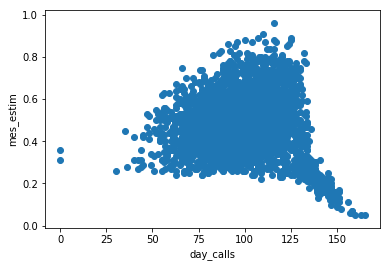

In [15]:
plt.scatter(data.day_calls, data.mes_estim)
plt.xlabel('day_calls')
plt.ylabel('mes_estim')
pass

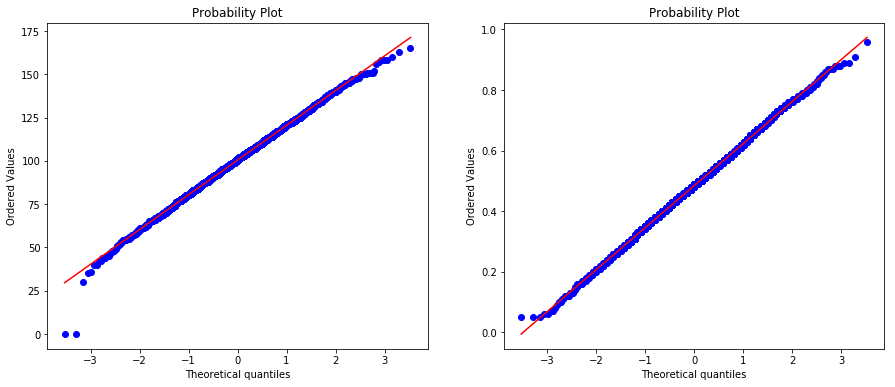

In [16]:
_ = plt.figure(figsize=(15,6))
_ = plt.subplot(121)
_ = scipy.stats.probplot(data.day_calls, dist="norm", plot=plt)
_ = plt.subplot(122)
_ = scipy.stats.probplot(data.mes_estim, dist="norm", plot=plt)

In [17]:
print('Pearson correlation value:', pearsonr(data.day_calls, data.mes_estim)[0])
print('p=value:', pearsonr(data.day_calls, data.mes_estim)[1])

Pearson correlation value: -0.051794350587572625
p=value: 0.0027798836869756707


Еще раз рассмотрим пару признаков day_calls и mes_estim. Посчитайте корреляцию Спирмена между этими признаками на всех данных, ее значимость.

In [18]:
print('Spearmen correlation value:', stats.spearmanr(data.day_calls, data.mes_estim)[0])
print('p=value:', stats.spearmanr(data.day_calls, data.mes_estim)[1])

Spearmen correlation value: 0.043349880533927444
p=value: 0.012317367189170541


Посчитайте значение коэффицента корреляции Крамера между двумя признаками: штатом (state) и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной группе (treatment=1). Что можно сказать о достигаемом уровне значимости при проверке гипотезы о равенство нулю этого коэффициента?


Достигаемый уровень значимости < 0.05, то есть, отличие от нуля значения 

In [19]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [92]:
my_list = [12, 65, 54, 39, 102, 339, 221, 50, 70, ] 
  
# use anonymous function to filter and comparing  
# if divisible or not 
result = list(filter(lambda x: (x % 13 == 0), my_list))  
  
# printing the result 
print(result) 

[65, 39, 221]


In [105]:
len(list(filter(lambda x: (x < 5), sparse_sales.iloc[1:].values[0])))

34

In [106]:
sparse_sales

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
churn,,,,,,,,,,,,,,,,,,,,,
False.,19,25,11,17,10,17,25,18,16,18,...,20,11,14,18,20,18,16,22,27,20
True.,1,5,5,2,5,5,5,1,1,2,...,3,1,6,4,3,5,7,2,5,2


In [20]:
print('V Cramer stat value: %.4f' %cramers_stat(sparse_sales.values))

V Cramer stat value: 0.2004


In [21]:
print('p-value: %.4f' % stats.chi2_contingency(sparse_sales.values)[1])

p-value: 0.7098


Вы прослушали большой курс и к текущему моменту обладете достаточными знаниями, чтобы попытаться самостоятельно выбрать нужный метод / инструмент / статистический критерий и сделать правильное заключение.

В этой части задания вам нужно будет самостоятельно решить, с помощью каких методов можно провести анализ эффективности удержания (churn) с помощью раличных методов (treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

Что можно сказать об этих двух методах (treatment = 0, treatment = 2)? Одинаковы ли они с точки зрения эффективности? Каким бы методом вы бы посоветовали воспользоваться компании?

Thus for each pair of samples we have to check hypotesys:
    
H0 treatment 0 and treatment 1 are from the same distribution

H0 treatment 0 and treatment 2 are from the same distribution

Each against two-sided alternative

In [35]:
# bin column for response column
data['binchurn'] = list(1 if x=='True.' else 0 for x in data.churn)

In [32]:
conf_interval_treatment_0 = proportion_confint(sum(data.binchurn[(data.treatment==0)]), 
                                            data.binchurn[(data.treatment==0)].shape[0],
                                            method = 'wilson')
conf_interval_treatment_1 = proportion_confint(sum(data.binchurn[(data.treatment==1)]), 
                                            data.binchurn[(data.treatment==1)].shape[0],
                                            method = 'wilson')
conf_interval_treatment_2 = proportion_confint(sum(data.binchurn[(data.treatment==2)]), 
                                            data.binchurn[(data.treatment==2)].shape[0],
                                            method = 'wilson')

In [33]:
print('interval for treatment 0 [%f, %f]' % conf_interval_treatment_0)
print('interval for tratment 1 [%f, %f]' % conf_interval_treatment_1)
print('interval for tratment 2 [%f, %f]' % conf_interval_treatment_2)

interval for treatment 0 [0.126289, 0.167368]
interval for tratment 1 [0.143347, 0.187165]
interval for tratment 2 [0.106880, 0.145949]


In [36]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [64]:
print('Condfidence interval treatment 1-0:', proportions_confint_diff_ind(
    data.binchurn[(data.treatment==1)], data.binchurn[(data.treatment==0)]))
print('Condfidence interval treatment 1-2:', proportions_confint_diff_ind(
    data.binchurn[(data.treatment==1)], data.binchurn[(data.treatment==2)]))

Condfidence interval treatment 1-0: (-0.011583241590025106, 0.04848883584089464)
Condfidence interval treatment 1-2: (0.00961876673809212, 0.06832230885668503)


In [43]:
def proportions_diff_z_stat_ind(sample1, sample2):
    """
    Z-criteria for Z-test
    """
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [44]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [68]:
print('p-value treatment 1-0:', proportions_diff_z_test(
                proportions_diff_z_stat_ind(data.binchurn[(data.treatment==1)], 
                data.binchurn[(data.treatment==0)]), alternative = 'two-sided'))
print('p-value treatment 1-2:', proportions_diff_z_test(
                proportions_diff_z_stat_ind(data.binchurn[(data.treatment==1)], 
                data.binchurn[(data.treatment==2)]), alternative = 'two-sided'))
print('p-value treatment 0-2:', proportions_diff_z_test(
                proportions_diff_z_stat_ind(data.binchurn[(data.treatment==0)], 
                data.binchurn[(data.treatment==2)]), alternative = 'two-sided'))

p-value treatment 1-0: 0.2283311639045107
p-value treatment 1-2: 0.009348084294451109
p-value treatment 0-2: 0.1564246886050802


In [69]:
_, p_corrected, _, _ = multipletests([0.2283311639045107, 0.009348084294451109, 0.1564246886050802],
                                     alpha = 0.05, method = 'fdr_bh') 
p_corrected

array([0.22833116, 0.02804425, 0.22833116])